# Initialization

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer, MissingIndicator

In [2]:
train=pd.read_csv('../data/data.csv.zip', compression='zip', index_col=1)
train=train.drop(columns=['Unnamed: 0'])

# Data cleaning

In [3]:
train.columns = train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
train=train.drop(columns=['photo', 'flag', 'club_logo'])

train['value_unit'] = train['value'].str[-1]
train['nvalue'] = np.where(train['value_unit'] == '0', 0,
                          train['value'].str[1:-1].replace(r'[a-zA-Z]',''))
train['nvalue'] = train['nvalue'].astype(float)
train['nvalue'] = np.where(train['value_unit'] == 'M', train['nvalue'], train['nvalue'] / 1000)

train['wage_unit'] = train['wage'].str[-1]
train['nwage'] = np.where(train['wage_unit'] == '0', 0,
                          train['wage'].str[1:-1].replace(r'[a-zA-Z]',''))
train['nwage'] = train['nwage'].astype(float)
train['nwage'] = np.where(train['wage_unit'] == 'K', train['nwage'], train['nwage'] * 1000)


# Features selection

In [4]:
features = ['aggression', 'age', 'potential', 
                        'international_reputation',
                        'weak_foot', 'skill_moves', 'crossing', 'finishing', 'headingaccuracy', 
                        'shortpassing', 'volleys', 'dribbling', 'curve', 'fkaccuracy', 'longpassing',
                        'ballcontrol', 'acceleration', 'sprintspeed',
                        'agility', 'reactions', 'balance', 'shotpower', 'jumping', 'stamina', 
                        'strength',
                        'longshots', 'aggression', 'interceptions', 'positioning', 'vision', 
                        'penalties',
                        'composure', 'marking', 'standingtackle', 'slidingtackle', 'gkdiving', 
                        'gkhandling', 'gkkicking', 'gkpositioning', 'gkreflexes']

target = ['overall']


# Drop missing values.

In [5]:
def drop_missing_values(train, columns):
    df = train.dropna(subset=columns)
    return df


In [6]:
t=features.copy()
t.append('overall')

In [7]:
# train_d = train.dropna(subset=t)
train_d = drop_missing_values(train, t)

In [8]:
X=train_d[features]
y=train_d.overall

# Define Models

In [9]:
models = []
models.append(('LR', linear_model.LinearRegression()))
models.append(('BR', linear_model.BayesianRidge(n_iter=1000)))
models.append(('Huber', linear_model.HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, 
                                                    max_iter=100, tol=1e-05, warm_start=False)))
models.append(('LarsCV', linear_model.LarsCV(max_iter=1000, eps=1.35, cv=10)))
models.append(('LassoCV', linear_model.LassoCV(max_iter=1000, cv=5)))
models.append(('RF', ensemble.RandomForestRegressor(n_estimators=10)))

# Model fitting and prediction

In [10]:
def model_score(name, model, X, y, val_y, y_pred, icv):
    cvscore = cross_val_score(model, X, y, cv=icv)
    print('Model {0} score: {1:.4f} and std dev: {2:.4f}'.format(name, cvscore.mean(), cvscore.std()))
    print('Variance score: %.4f' % r2_score(val_y, y_pred))
    return cvscore, r2_score(val_y, y_pred)


## Using cross validation

In [11]:
def cv_fit_and_predict(models, X, y):
    results = []
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
    for name, model in models:
        model.fit(train_X, train_y)
        y_pred = model.predict(val_X)
        score, r2 = model_score(name, model, X, y, val_y, y_pred, 10)
        results.append((name, score, r2))
    print("Done")
    return results


In [12]:
#results = cv_fit_and_predict(models, X, y)

Model LR score: -4.1394 and std dev: 1.8521
Variance score: 0.9274
Model BR score: -4.1150 and std dev: 1.8285
Variance score: 0.9274
Model Huber score: -5.0193 and std dev: 3.0496
Variance score: 0.9131
Model LarsCV score: -10.4568 and std dev: 10.8087
Variance score: 0.8438
Model LassoCV score: -4.0390 and std dev: 1.7494
Variance score: 0.9264
Model RF score: -6.7792 and std dev: 9.1132
Variance score: 0.9685
Done


# Validation and Results

In [13]:
def model_validation(results):
    fig, ax = plt.subplots()
    ax.boxplot(results[:,1])
    ax.set_xticklabels(results[:,0])
    ax.set_title('Model CV score')
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.bar(results[:,0], results[:,2])
    plt.xlabel('Models')
    plt.ylabel('Var score')
    plt.title('Models variance score')
    plt.show()
    
    return 0

In [14]:
#results=np.array(results)

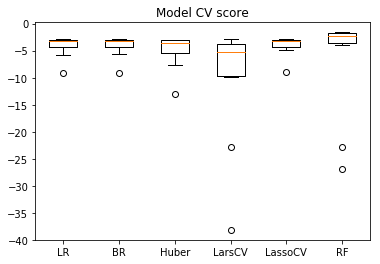

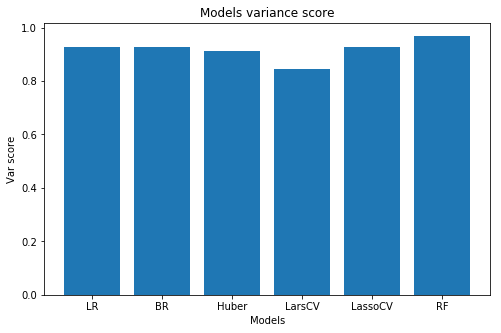

In [15]:
#status = model_validation(results)

# Handling missing values - Imputation

In [16]:
def imputation_cv(models, X, y):
    results = []
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
    for name, model in models:
        my_pipeline = make_pipeline(SimpleImputer(), model)
        my_pipeline.fit(train_X, train_y)
        y_pred = my_pipeline.predict(val_X)
        score, r2 = model_score(name, my_pipeline, X, y, val_y, y_pred, 10)
        results.append((name, score, r2))
    print("Done")
    return results


In [17]:
X = train[features]
y = train.overall
results = imputation_cv(models, X, y)

Model LR score: -4.1452 and std dev: 1.8398
Variance score: 0.9235
Model BR score: -4.1206 and std dev: 1.8161
Variance score: 0.9235
Model Huber score: -5.0986 and std dev: 3.1542
Variance score: 0.9084
Model LarsCV score: -10.4628 and std dev: 10.7611
Variance score: 0.8372
Model LassoCV score: -4.0444 and std dev: 1.7382
Variance score: 0.9224
Model RF score: -6.7904 and std dev: 9.0860
Variance score: 0.9681
Done


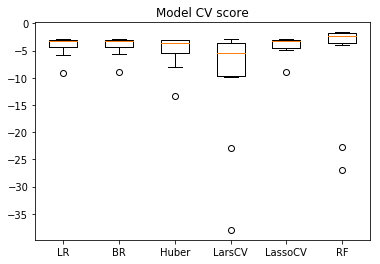

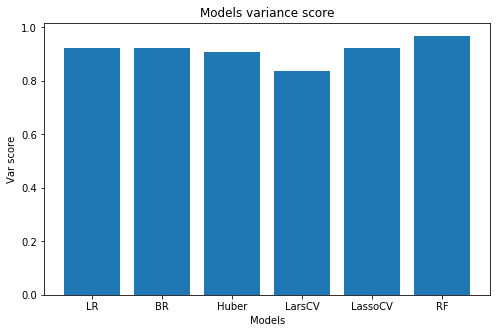

In [18]:
results=np.array(results)
status = model_validation(results)

# Imputation extension 

In [19]:
train.columns

Index(['name', 'age', 'nationality', 'overall', 'potential', 'club', 'value',
       'wage', 'special', 'preferred_foot', 'international_reputation',
       'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face',
       'position', 'jersey_number', 'joined', 'loaned_from',
       'contract_valid_until', 'height', 'weight', 'ls', 'st', 'rs', 'lw',
       'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm',
       'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb',
       'crossing', 'finishing', 'headingaccuracy', 'shortpassing', 'volleys',
       'dribbling', 'curve', 'fkaccuracy', 'longpassing', 'ballcontrol',
       'acceleration', 'sprintspeed', 'agility', 'reactions', 'balance',
       'shotpower', 'jumping', 'stamina', 'strength', 'longshots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standingtackle', 'slidingtackle', 'gkdiving',
       'gkhandling', 'gkkicking', 'gk

In [20]:
# make copy to avoid changing original data (when Imputing)
new_data = X.copy()

# make new columns indicating what will be imputed
cols_with_missing = (col for col in new_data.columns 
                                 if new_data[col].isnull().any())
for col in cols_with_missing:
    new_data[col + '_was_missing'] = new_data[col].isnull()

# Imputation
my_imputer = SimpleImputer()
new_data = pd.DataFrame(my_imputer.fit_transform(new_data))
new_data.columns = X.columns


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().